# Principal Component Analysis (PCA)
## Motivation

Dimensionality reduction is a fundamental concept in machine learning, aiming to exploit relationships among points in high-dimensional space in order to construct some low-dimensional summaries. By doing so, this process eliminates redundancies, while preserving interesting characteristics of the data. In turn, we can use dimensional reduction techniques to extract interesting features and improve the computational tractability of downstream machine learning algorithms as well as to visualize data which are comprised of many interrelated variables.

The idea of dimension reduction is really not new and dates back to Pearson(1901) and Hotelling (1933) who have invented principal component analysis (PCA). Today, PCA is the most widely used (linear) dimension reduction technique, due to its simple geometric interpretation. And all you need to know to understand PCA are some basic concepts from linear algebra.

To gain some intution, let's consider an example in 2 dimensions. Here we consider two variables, $X_1$ which is the weight of each of $n=145$ students in the fifth grade, and $X_2$ which is each student's corresponding height. We're interested in seeing how "related" the two variables are, e.g. in the sense that changes in the value of one variable "predict" changes in the value of the other variable.

First, let's plot the sample points to get an idea of what we are working with.

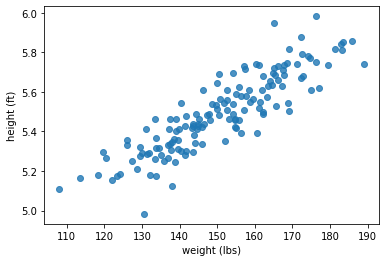

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)
x = np.random.standard_normal(size=145)*15 + 150 # weight (lbs)
y = 0.01 * x + np.random.standard_normal(size=145)*0.1 + 4 # height (ft)

plt.scatter(x, y, alpha=0.8)
plt.xlabel("weight (lbs)")
plt.ylabel("height (ft)")
plt.show()

To quantify whether there is some relationship between height and weight we could for example compute the (cosine of the) angle $\gamma$ between two vectors to provide a notion of closeness.

$$
 \gamma = \cos(\theta) = \frac{\boldsymbol{x}^\top \boldsymbol{y}}{\|\boldsymbol{x}\|_2\|\boldsymbol{y}\|_2} .
$$

If we mean center both $\boldsymbol{x}$ and $\boldsymbol{y}$ in addition, we obtain Pearson's correlation coefficient $r_{XY}$

$$
 r_{XY} =  \frac{ (\boldsymbol{x}-\bar{x})^\top (\boldsymbol{y}-\bar{y})  }{\|\boldsymbol{x}-\bar{x}\|_2\|\boldsymbol{y}-\bar{y}\|_2},
$$

where $\bar{x}$ is the sample mean

$$ \bar{x} = \frac{1}{n} \sum_i x_i. $$

(If you don't recall Pearson's correlation coefficient, check out this wiki: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient.)

Let's compute $r_{XY}$ for our data.

In [2]:
x -= np.mean(x) # mean center x
y -= np.mean(y) # mean center y
xy = np.dot(x,y) # compute dot product between x and y
x_norm = np.linalg.norm(x) # euclidean norm of x
y_norm = np.linalg.norm(y) # euclidean norm of y
r = xy / (x_norm * y_norm)
print(r)

0.8781109535909715


So the correlation coefficient indicates that there is a relationship between the height and weight, i.e., if you only know the weight of a person, you can make an educated guess about the person's height and vice versa. The closer the correlation coefficient is to 1, the more related the two variables.

Given that the variables height and weight seem to be very highly correlated, it is reasonable to ask whether we can form a new variable that summarizes both weight and height. A natural form for such a summary variable would be some linear combination of weight and height, e.g.

$$
Z = a X + b Y = \begin{bmatrix} a & b \end{bmatrix}  \begin{bmatrix} X\\ Y\end{bmatrix}.
$$

As we will see in the remainder of this section, principal component analysis allows us to construct such summary variables in a principled manner.

## Basics of PCA

Suppose we have observed $n$ observations $\boldsymbol{x}_1,\dots,\boldsymbol{x}_n \in \mathbb{R}^p$, where each $x_{ij}$ corresponds to the $j^{th}$ feature for observation $i$. For convenience, we often represent this data as an $n\times p$ "design matrix" given by

$$
\boldsymbol{X} = \begin{bmatrix} - & \boldsymbol{x}_1 & - \\  &\vdots & \\ - & \boldsymbol{x}_n & - \end{bmatrix} \in \mathbb{R}^{n\times p}
$$

In many circumstances, these $p$ features may be highly correlated with one another. When $p > 2$ dimensions, there are two common ways to capture this correlation structure. The first is with the covariance matrix, which given by

$$
\boldsymbol{C} = \frac{1}{n}(\boldsymbol{X} - \bar{\boldsymbol{x}})^\top (\boldsymbol{X}-\bar{\boldsymbol{x}})
$$

where $\bar{\boldsymbol{x}}$ is the vector containing the means of each of the columns of $\boldsymbol{X}$, i.e. $\bar{x}_j = \frac{1}{n}\sum_{i=1}^n x_{ij}$. Note that we are abusing notation by writing $\boldsymbol{X}-\bar{\boldsymbol{x}}$, as the first object is a matrix and the second is a vector, though what we really mean here is that we are substracting the number $\bar{x}_j$ from each of the entries in the $j^{th}$ column of $\boldsymbol{X}$. Another way to compute this in practice is by defining the _centering matrix_ $\boldsymbol{H} = \boldsymbol{I} - \frac{1}{n}\boldsymbol{11}^\top$, then we can mean-center the columns of $\boldsymbol{X}$ by applying $\boldsymbol{H}$ on the left, i.e. with $\boldsymbol{HX}$.

The covariance matrix $\boldsymbol{C}$ contains all the pairwise covariances between the features, so that

$$
\boldsymbol{C}_{jk} = \frac{1}{n}\sum_{i=1}^n (x_{ij} - \bar{x}_j)(x_{ik} - \bar{x}_k).
$$

As we will see later, it will often make sense to consider a normalized version of the covariance matrix called the correlation matrix, which is given by

$$
\boldsymbol{R} = \boldsymbol{D}^{-1/2}\boldsymbol{C}\boldsymbol{D}^{-1/2}
$$

where $\boldsymbol{D}$ is a diagonal matrix with $\boldsymbol{D}_{jj} = \frac{1}{n}\sum_{i=1}^n (x_{ij} - \bar{x}_j)^2$. Note that the correlation matrix corresponds to the covariance matrix associated with the normalized features $\tilde{X}_j = X_j/\sqrt{\text{Var}(X_j)}$. Note that both $\boldsymbol{C}$ and $\boldsymbol{R}$ are always symmetric matrices.

The goal of principal component analysis is to find $k \leq p$ new summary variables that capture as much information in the original data as possible, but in fewer dimensions. Formally, we want to find new variables $\boldsymbol{z}_1,\dots,\boldsymbol{z}_k$ which are linear combinations of the original features, of the form

$$
\begin{align*}
\boldsymbol{z}_1 &=\boldsymbol{X}\boldsymbol{u}_1\\
\vdots \\
\boldsymbol{z}_k &= \boldsymbol{X}\boldsymbol{u}_k.
\end{align*}
$$

Here we require the following out of the new features:

1. The summarize as much of the variation in the original data as possible
2. They are independent, in the sense that $\boldsymbol{u}_j^\top \boldsymbol{u}_l = 0$ if $j\neq l$
3. The vectors $\boldsymbol{u}_j$ are unit vectors.

To see how this works out, we can write down the optimization problem for the first feature $\boldsymbol{z}_1$.

$$
\max_{\|\boldsymbol{u}_1\|_2 = 1} \text{Var}(\boldsymbol{Xu}_1)
$$

Now using some basic properties of variances, it is easy to show that

$$
\text{Var}(\boldsymbol{Xu}_1) = \boldsymbol{u}_1^\top \boldsymbol{C}\boldsymbol{u}_1
$$

which we recognize as a quadratic form associated with the symmetric matrix $\boldsymbol{C}$. Plugging this into our original variance maximization problem, we find

$$
\max_{\|\boldsymbol{u}_1\|_2 = 1} \text{Var}(\boldsymbol{Xu}_1) = \max_{\|\boldsymbol{u}_1\|_2 = 1} \boldsymbol{u}_1^\top \boldsymbol{C}\boldsymbol{u}_1
$$

This is an optimization problem we've seen before! The solution to this problem is exactly given by the top eigenvector (i.e. associated with the largest eigenvalue) of the covariance matrix $\boldsymbol{C}$. Moreover, the rest of the solutions of the rest of the vectors $\boldsymbol{u}_2,\dots, \boldsymbol{u}_k$ are just the next $k-1$ eigenvectors. In the context of PCA, the eigenvectors $\boldsymbol{u}_j$ are typically called the _loadings_, and the new features $\boldsymbol{z}_j = \boldsymbol{Xu}_j$ are called the _scores_.

Hence the problem of PCA, defined is exactly solved by finding the eigenvalue decomposition of the covariance matrix $\boldsymbol{C}$.

Let's briefly return to the toy example of height and weight introduced earlier. First, let's construct the design matrix $\boldsymbol{X}$.

In [3]:
X = np.vstack((x,y)).T
X.shape

(145, 2)

Next, let's construct the covariance matrix $\boldsymbol{C}$.

In [4]:
C = 1/(X.shape[0]) * np.dot(X.T, X)

(recall that we already mean-centered the data). Next, lets compute the eigenvalue decomposition of the covariance matrix.

In [5]:
eigenvals, eigenvecs = np.linalg.eig(C)

Now let's visualize the top eigenvectors overlayed on top of our data. (Note we rescale them by a factor of 10 so that we can visualize it on the plot)

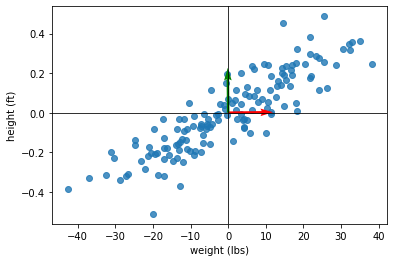

In [6]:
origin = np.array((0,0))
plt.scatter(x, y, alpha=0.8)
plt.xlabel("weight (lbs)")
plt.ylabel("height (ft)")
# plot the vector u1
plt.quiver(*origin, *(10*eigenvecs[:,0]), color=['r'], scale=1, units='xy')
# plot the vector u2
plt.quiver(*origin, *(10*eigenvecs[:,1]), color=['g'], scale=1, units='xy')
plt.axhline(y=0, color='k', linestyle='-', lw=0.8)
plt.axvline(x=0, color='k', linestyle='-', lw=0.8)
plt.show()

Strangely, this doesn't seem to do as well as we might have hoped -- the top eigenvector seems to be primarily aligned with the weight axis. It turns out this is primarily due to an issue of scale, in particular the fact that the scale on the weight feature (in lbs) is much larger than the scale of the height feature (in ft). This can be resolved by using the correlation matrix instead of the covariance matrix. So, let's repeat the above steps but using the normalized features instead.

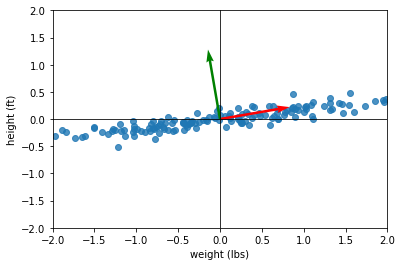

In [7]:
x /= np.var(x)**0.5
y /= np.var(x)**0.5

X = np.vstack((x,y)).T
R = 1/(X.shape[0]) * X.T.dot(X)

eigenvals, eigenvecs = np.linalg.eig(R)

origin = np.array((0,0))
plt.scatter(x, y, alpha=0.8)
plt.xlabel("weight (lbs)")
plt.ylabel("height (ft)")
# plot the vector u1
plt.quiver(*origin, *eigenvecs[:,0], color=['r'], scale=1, units='xy')
# plot the vector u2
plt.quiver(*origin, *eigenvecs[:,1], color=['g'], scale=1, units='xy')
plt.axhline(y=0, color='k', linestyle='-', lw=0.8)
plt.axvline(x=0, color='k', linestyle='-', lw=0.8)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

Now the first eigenvector seems to be aligned with the direction corresponding to the most variation in the data, which was exactly the goal of the PCA. In general, the issue of having features with different scales appears frequently in practice, and so it is always recommend to work with normalized features, and hence the correlation matrix, rather than the unnormalized covariance matrix.

## The role of the eigenvalues

Previously we saw that the eigenvectors of the covariance/correlation represent the directions of maximal variation in the data. It turns out that the eigenvalues also have a valuable interpretation when performing PCA. First, we observe that the variance of the $j^{th}$ feature $\boldsymbol{z}_j$ is exactly equal to the $j^{th}$ eigenvalue:

$$
\text{Var}(\boldsymbol{z}_j) = \text{Var}(\boldsymbol{X}\boldsymbol{u}_j) = \boldsymbol{u^\top_j C u_j} = \lambda_j.
$$

Moreover, the total amount of variance in the data is given by

$$
\sum_{j=1}^p \boldsymbol{C}_{jj} = \text{Trace}(\boldsymbol{C}) = \sum_{j=1}^p \lambda_j.
$$

Therefore, we can intepret the ratio

$$
\frac{\lambda_m}{\sum_{j=1}^p \lambda_j}
$$

as the _proportion of variance described by the $m^{th}$ component_. This is very valuable in practice when selecting how many dimensions we want to use. For example, in a simple height/weight problem, the proportion of variance described by the first direction is

In [8]:
print(eigenvals[0]/(eigenvals[0]+eigenvals[1]))

0.9918782443031121


This tells us that we can explain more than 99% of the variance in the data by just considering the first component! This suggests that this data can be very well described using only one dimension (i.e. the feature $\boldsymbol{z}_1$) rather than the original two features height and weight.

Before proceeding to show a more realistic application of PCA, we will see that all the above steps can equivalently be performed using the singular value decomposition.

## PCA from the SVD

In this section, we briefly show how the principal component analysis as derived above can equivalently be stated in terms of the singular value decomposition.

Recall that the SVD writes an $n\times p$ matrix $\boldsymbol{X}$ as $\boldsymbol{X} = \boldsymbol{U\Sigma V}^\top$, where $\boldsymbol{U}$ are the eigenvectors obtained from the EVD of $\boldsymbol{XX^\top}$, $\boldsymbol{V}$ are the eigenvectors obtained from the EVD of $\boldsymbol{X^\top X}$, and $\boldsymbol{\Sigma}$ contains the square-roots of the non-zero eigenvalues from either $\boldsymbol{X^\top X}$ or $\boldsymbol{XX^\top}$. Now remember from above that we found the principal components by considering the eigenvalue decomposition of the matrix

$$
\boldsymbol{C} = \frac{1}{n}\boldsymbol{X}_c^\top\boldsymbol{X}_c
$$

where $\boldsymbol{X}_c = \boldsymbol{HX}$ is the data matrix with the columns mean-centered. Then the eigenvectors of $\boldsymbol{C}$ are the same as the right singular vectors of $\boldsymbol{X}_c$, and the eigenvalues of $\boldsymbol{C}$ are given by $\lambda_i = \frac{1}{n}\sigma_i^2$, where $\sigma_i$ is the $i^{th}$ singular value of $\boldsymbol{X}_c$.

## An example with handwritten digits

Here we will apply PCA to a dataset containing images of handwritten digits. We can load and visualize the dataset using the following:

X has shape (1797, 64)


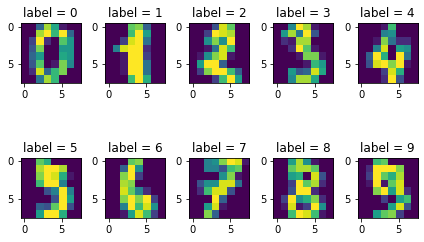

In [9]:
from sklearn.datasets import load_digits

dataset = load_digits()
X = dataset.data
labels = dataset.target

print(f'X has shape {X.shape}')

fig, axs = plt.subplots(2, 5)
axs = axs.flatten()

for ix in range(10):
    axs[ix].imshow(X[ix].reshape(8,8))
    axs[ix].set_title(f'label = {labels[ix]}')

plt.tight_layout()
plt.show()

Note that the matrix $\boldsymbol{X}$ has shape $1797 \times 64$, where $64$ corresponds to the fact that each image is $8\times 8$. Next, let's mean-center the data matrix and compute the covariance matrix.

In [10]:
# centering matrix
ones = np.ones(X.shape[0])
H = np.eye(X.shape[0]) - (1./X.shape[0])*np.outer(ones, ones)

# mean-center data by applying the centering matrix
Xc = np.dot(H, X)

# compute the covariance matrix
C = (1./X.shape[0])*np.dot(Xc.T, Xc)

Next, we can compute the eigenvalue decomposition of the covariance.

In [11]:
eigenvals, eigenvecs = np.linalg.eig(C)

# make sure the eigenvalues are sorted largest to smallest
sorted_ix = np.flip(np.argsort(eigenvals))
eigenvals = eigenvals[sorted_ix]
eigenvecs = eigenvecs[sorted_ix]

How many dimensions do we need to faithfully represent this dataset? One way to get an understanding of this is by plotting the proportion of variance described by each dimension. Recall that this is given by $\lambda_m / \sum_{j} \lambda_j$. Such a plot is called a _scree plot_.

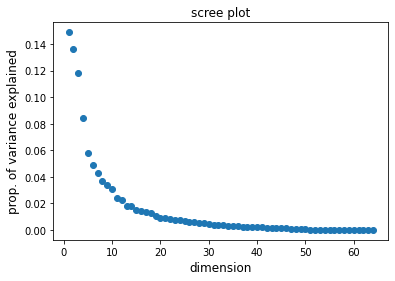

In [12]:
plt.scatter(range(1,len(eigenvals)+1), eigenvals/np.sum(eigenvals))
plt.xlabel('dimension', fontsize=12)
plt.ylabel('prop. of variance explained', fontsize=12)
plt.title('scree plot', fontsize=12)
plt.show()

We can see that the first few dimensions do seem to capture much of the variance in the data. Let's try computing and visualizing the first three principal components.

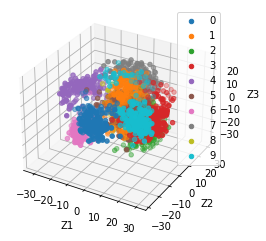

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# compute the first 3 PCs by projecting the data onto the top 3 eigenvectors
z1 = np.dot(X, eigenvecs[:,0])
z2 = np.dot(X, eigenvecs[:,1])
z3 = np.dot(X, eigenvecs[:,2])

for l in range(10):
    ax.scatter(z1[labels==l],z2[labels==l],z3[labels==l], label=l)

ax.set_xlabel('Z1')
ax.set_ylabel('Z2')
ax.set_zlabel('Z3')

plt.legend()
plt.show()

As we can see from the plot, the principal components provide a nice way to visualize data that is high dimensional.